# 高速化
* cython
* numba
* 再帰関数の部分をメモ化するか動的計画法を使う
    - メモ化に関して、メモの使わない部分のメモリがもったいない

In [1]:
import itertools
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra #フィボナッチヒープを使用している
import math
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import time
from InfMaxProblem import ICmodel
import sys
sys.setrecursionlimit(20000)

%matplotlib inline

### ランダムグラフ作成関数

In [2]:
def make_random_graph(V_size, E_size):
    E = np.zeros(V_size**2)
    p = np.zeros(V_size**2)
    
    index_list = [i for i in range(V_size**2) if i%(V_size+1) != 0]
    
    for i in tqdm(random.sample(index_list, k=E_size)):
        E[i] = 1
        p[i] = random.randint(1,100)/100
    E = E.reshape(V_size, V_size)
    p = p.reshape(V_size, V_size)
    
    return [E, p]

In [3]:
g = make_random_graph(10000, 20000)
E = g[0]
p = g[1]

In [4]:
# E
# [[0., 1., 0., 0., 0., 0., 0.],
#        [0., 0., 0., 0., 0., 0., 1.],
#        [0., 0., 0., 0., 0., 1., 0.],
#        [1., 0., 1., 0., 0., 0., 1.],
#        [0., 0., 0., 1., 0., 1., 1.],
#        [0., 0., 0., 0., 0., 0., 0.],
#        [0., 0., 0., 0., 0., 0., 0.]]

In [5]:
# p 
# [[0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  ],
#        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.34],
#        [0.  , 0.  , 0.  , 0.  , 0.  , 0.88, 0.  ],
#        [0.56, 0.  , 0.24, 0.  , 0.  , 0.  , 0.32],
#        [0.  , 0.  , 0.  , 0.48, 0.  , 0.05, 0.78],
#        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
#        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]]

In [6]:
G = nx.DiGraph(E)

In [7]:
#fig = plt.figure(figsize=(15,10))
#nx.draw_networkx(G)

In [8]:
# 隣接行列を隣接リストに変換する
def edge_list_change(E):
    E_list = []
    for i, E_i in enumerate(E):
        for j, E_i_j in enumerate(E_i):
            if E_i_j > 0:
                E_list.append([i,j])
    return E_list

In [9]:
# 隣接行列を隣接リストに変換する(確率付き)
def edge_p_list_change(E,p):
    E_list = []
    for i, E_i in enumerate(E):
        for j, E_i_j in enumerate(E_i):
            if E_i_j > 0:
                E_list.append([i,j,p[i][j]])
    return E_list

In [10]:
# edge_p_list_change(E,p)

In [11]:
def get_pass(start, end, pass_info):
    shortest_pass = []
    t = end
    while t != -9999:
        shortest_pass.append(t)
        t = pass_info[t]
        if t == start:
            shortest_pass.append(start)
            shortest_pass.reverse()
            return shortest_pass
    return []

In [12]:
# 任意の頂点からvへの最短経路とvへの到達確率を求める関数
def MIIOA(p, theta):
    V_size = len(p)
    
    # limitでtheta以下になるようなパスを探索しなくなる
    result = dijkstra(csr_matrix(-np.log(p)), return_predecessors=True, limit=-np.log(theta))
    
    # 任意のuから任意のvまでの最短距離を最大確率に変換
    shortest_distance = np.exp(1)**(-result[0])
    
    # 任意のuから任意のvまでの最短経路を保存
    MIIA = [[get_pass(u,v,result[1][u]) for u in range(V_size) if get_pass(u, v, result[1][u]) != []] 
            for v in range(V_size)]
    MIOA = [[get_pass(u,v,result[1][u]) for v in range(V_size) if get_pass(u, v, result[1][u]) != []] 
            for u in range(V_size)]
    return [MIIA, MIOA, shortest_distance]

# vまでのMIPの確率がtheta以上のパスを列挙する関数
def MIIA(v, info):
    return info[0][v]

# vから各頂点のMIPの確率がtheta以上のパスを列挙する関数
def MIOA(v, info):
    return info[1][v]


def pp(u, v, info):
    return info[2][u][v]

# info = MIIOA(p, 0.01)
# print(MIIA(5,info))
# print(MIOA(5,info))
# print(pp(0,5,info))
# [[0, 9, 3, 5], [1, 2, 6, 9, 3, 5], [2, 6, 9, 3, 5], [3, 5], [6, 9, 3, 5], [7, 2, 6, 9, 3, 5], [9, 3, 5]]
# [[5, 3], [5, 6], [5, 6, 9]]
# 0.169344

In [13]:
# info = MIIOA(p, 0.01)
# print(MIOA(3,info))
# print(MIIA(2,info))

In [14]:
# MIIA(v, theta)で得られた木において、uのincoming頂点集合(uに入ってくる頂点集合)
def N_in(u, MIIA_trees):
    N_in_nodes = []
    for tree in MIIA_trees:
        if u in tree:
            N_in_index = tree.index(u) - 1
            if N_in_index >= 0:
                N_in_nodes.append(tree[N_in_index])
    return list(set(N_in_nodes))

#info = MIIOA(p, 0.01)
# N_in(9, MIIA(5, info))
# [0, 6]

In [15]:
# MIIA(v, theta)で得られた木において、uのoutcoming頂点(uから出ていく頂点集合)
def N_out(u, MIIA_trees):
    for tree in MIIA_trees:
        if u in tree:
            N_out_index = tree.index(u) + 1
            if N_out_index < len(tree):
                return tree[N_out_index]
    return None

# N_out(9, MIIA(5, info))
# 3

In [16]:
def ap(u, S, MIIA_trees, info):
    if u in S:
        return 1
    elif len(N_in(u, MIIA_trees)) == 0:
        return 0
    else:
        N_in_u = N_in(u, MIIA_trees)
        prod = 1
        for w in N_in_u:
            prod *= (1 - ap(w, S, MIIA_trees, info)*pp(w, u, info))
        return 1 - prod

# ap(5, [7,9], MIIA(2, info), info)
# 0.3358000000000001

In [17]:
def ap_memo_func(u, S, v, MIIA_trees, info):
    if u in S:
        ap_memo[u][v] = 1
        return ap_memo[u][v]
    
    elif len(N_in(u, MIIA_trees)) == 0:
        ap_memo[u][v] = 0
        return ap_memo[u][v]
    
    #elif ap_memo[u][v] != -1:
        #return ap_memo[u][v]
    
    else:
        N_in_u = N_in(u, MIIA_trees)
        prod = 1
        for w in N_in_u:
            prod *= (1 - ap_memo_func(w, S, v, MIIA_trees, info)*pp(w, u, info))
        ap_memo[u][v] = 1 - prod
        return ap_memo[u][v]

In [18]:
# info = MIIOA(p, 0.001)
# ap_memo = [[-1]*len(p) for i in range(len(p))]

# #１回目の呼び出しだと遅いが。。。
# %time print(ap(3, [218,250], MIIA(3, info), info))
# %time print(ap_memo_func(3, [218,250], 3, MIIA(3, info), info))

# #２回目には計算されて埋められているところが出てくるので、速くなる
# %time print(ap(92, [218,250], MIIA(3, info), info))
# %time print(ap_memo_func(92, [218,250], 3, MIIA(3, info), info))

# %time print(ap(247, [218,250], MIIA(3, info), info))
# %time print(ap_memo_func(247, [218,250], 3, MIIA(3, info), info))

# 0.027197813972393292
# CPU times: user 2.79 s, sys: 1.79 ms, total: 2.8 s
# Wall time: 2.8 s
# 0.027197813972393292
# CPU times: user 2.8 s, sys: 3.53 ms, total: 2.8 s
# Wall time: 2.8 s
# 0.05912568254868111
# CPU times: user 917 ms, sys: 2.05 ms, total: 919 ms
# Wall time: 925 ms
# 0.05912568254868111
# CPU times: user 7.75 ms, sys: 153 µs, total: 7.91 ms
# Wall time: 7.87 ms
# 0.0
# CPU times: user 1.31 s, sys: 2.35 ms, total: 1.31 s
# Wall time: 1.31 s
# 0.0
# CPU times: user 8.38 ms, sys: 149 µs, total: 8.53 ms
# Wall time: 8.51 ms

In [19]:
def sigma_M(S, info):
    V_size = len(info[2])
    result = 0
    for v in range(V_size):
        result += ap(v, S, MIIA(v, info), info)
    return result

# sigma_M([1], info, p)
# 2.2380243040000005

In [20]:
# 考え得るuはMIIA_treesに含まれているノード
def compute_alpha(v, u, MIIA_trees, S, info):
    if u == v:
        return 1
    else:
        w = N_out(u, MIIA_trees)
        if w in S:
            return 0
        else:
            N_in_w_not_u = list(set(N_in(w, MIIA_trees)) - set([u]))
            prod = 1
            for u_ in N_in_w_not_u:
                prod *= (1 - ap(u_, S, MIIA_trees, info)*pp(u_, w, info))
            return compute_alpha(v, w, MIIA_trees, S, info) * pp(u, w, info) * prod

# compute_alpha(0,7,MIIA(0,info),[3],info)
# 0.43

In [21]:
# 考え得るuはMIIA_treesに含まれているノード
def compute_alpha_memo(v, u, MIIA_trees, S, info):
    if u == v:
        alpha_memo[v][u] = 1
        return alpha_memo[v][u]
    
    #elif alpha_memo[v][u] != -1:
        #return alpha_memo[v][u]
    
    else:
        w = N_out(u, MIIA_trees)
        
        if w in S:
            alpha_memo[v][u] = 0
            return alpha_memo[v][u]
        
        else:
            N_in_w_not_u = list(set(N_in(w, MIIA_trees)) - set([u]))
            prod = 1
            for u_ in N_in_w_not_u:
                prod *= (1 - ap_memo_func(u_, S, v, MIIA_trees, info)*pp(u_, w, info))
            alpha_memo[v][u] = compute_alpha_memo(v, w, MIIA_trees, S, info) * pp(u, w, info) * prod
            return alpha_memo[v][u]

In [22]:
# %time info = MIIOA(p, 0.001)
# %time ap_memo = [[-1]*len(p) for i in range(len(p))]
# %time alpha_memo = [[-1]*len(p) for i in range(len(p))]

# %time print(compute_alpha(0,1,MIIA(0,info),[3],info))
# %time print(compute_alpha_memo(0,1,MIIA(0,info),[3],info))

# %time print(compute_alpha(0,4,MIIA(0,info),[3],info))
# %time print(compute_alpha_memo(0,4,MIIA(0,info),[3],info))

# CPU times: user 34.8 s, sys: 151 ms, total: 34.9 s
# Wall time: 34.8 s
# CPU times: user 73 µs, sys: 0 ns, total: 73 µs
# Wall time: 78 µs
# CPU times: user 1.34 ms, sys: 0 ns, total: 1.34 ms
# Wall time: 1.35 ms
# 0.17396026358889893
# CPU times: user 2.93 s, sys: 3.7 ms, total: 2.94 s
# Wall time: 2.94 s
# 0.17396026358889893
# CPU times: user 2.92 s, sys: 3.99 ms, total: 2.93 s
# Wall time: 2.93 s
# 0.372870804167888
# CPU times: user 2.39 s, sys: 2.66 ms, total: 2.39 s
# Wall time: 2.39 s
# 0.372870804167888
# CPU times: user 54 µs, sys: 13 µs, total: 67 µs
# Wall time: 63.2 µs

In [23]:
# 遅いから使ってない
# 二次元リストを一次元リストに変換し、重複削除する関数
def ll_to_l(ll):
    l = []
    for i in ll:
        l += i
    l = list(set(l))
    return l

In [24]:
def MIA(p, k, theta):
    # initialization
    S = []
    V_size = len(p)
    IncInf = [0 for v in range(V_size)]
    
    info = MIIOA(p, theta)
    
    MIIA_sets = info[0]
    MIOA_sets = info[1]
    
    # ノードの集合
    MIIA_node_sets = [list(set(itertools.chain.from_iterable(MIIA(v, info)))) for v in range(V_size)]
    MIOA_node_sets = [list(set(itertools.chain.from_iterable(MIOA(v, info)))) for v in range(V_size)]
    
    for v in range(V_size):
        # ノードの集合
        MIIA_node = MIIA_node_sets[v]
        MIOA_node = MIOA_node_sets[v]
        
        MIIA_set = MIIA_sets[v]
        #6 不明
        #7 不明
        for u in MIIA_node:
            IncInf[u] += compute_alpha(v, u, MIIA_set, S, info)

    # main loop
    for i in range(k):
        # 14
        # max-heapでnlognでする必要あり?
        max_value = - float("inf")
        u = None
        for v in range(V_size):
            if v not in S:
                if max_value < IncInf[v]:
                    max_value = IncInf[v]
                    u = v
        # 15
        MIOA_sub_S = list(set(MIOA_node_sets[u]) - set(S))
        # uの影響力はMIOA(u,theta)にしか伝わらない。MIOA(u,theta)はuから伸びた枝を示している
        for v in MIOA_sub_S:
            # 17
            MIIA_sub_S = list(set(MIIA_node_sets[v]) - set(S))
            # vはMIOA(u,theta)の中にあるのでvは影響を受け、その影響をうけたvに入っているMIIA(v,theta)のwは更新する必要がある
            # vはもうuから影響を受けてしまったので、そのvに流れ込むwはvへ影響を及ぼしづらくなるため、下方修正が必要
            for w in MIIA_sub_S:
                IncInf[w] -= compute_alpha(v, w, MIIA_sets[v], S, info) * (1 - ap(w, S, MIIA_sets[v], info))
        # 22
        S.append(u)
        #23
        MIOA_sub_S = list(set(MIOA_node_sets[u]) - set(S))
        for v in MIOA_sub_S:
            #24 不明
            #25 不明
            # 26
            MIIA_sub_S = list(set(MIIA_node_sets[v]) - set(S))
            for w in MIIA_sub_S:
                IncInf[w] += compute_alpha(v, w, MIIA_sets[v], S, info) * (1 - ap(w, S, MIIA_sets[v], info))
    return S

# MIA(p, 2, 0.01)
# [7, 9]
# %time MIA(p, 2, 0.01)
# node = 50 edge=140
# Wall time: 6min 18s
# [15, 34]

In [25]:
def MIA_memo(p, k, theta):
    # initialization
    S = []
    V_size = len(p)
    IncInf = [0 for v in range(V_size)]
    
    info = MIIOA(p, theta)
    
    MIIA_sets = info[0]
    MIOA_sets = info[1]
    
    # ノードの集合
    MIIA_node_sets = [list(set(itertools.chain.from_iterable(MIIA(v, info)))) for v in range(V_size)]
    MIOA_node_sets = [list(set(itertools.chain.from_iterable(MIOA(v, info)))) for v in range(V_size)]
    
    global alpha_memo
    alpha_memo = [[-1]*len(p) for j in range(len(p))]
    global ap_memo
    ap_memo = [[0]*len(p) for j in range(len(p))]
    for v in range(V_size):
        # ノードの集合
        MIIA_node = MIIA_node_sets[v]
        MIOA_node = MIOA_node_sets[v]
        
        MIIA_set = MIIA_sets[v]
        # 6
        
        # 7
        for u in MIIA_node:
            compute_alpha_memo(v, u, MIIA_set, S, info)

        for u in MIIA_node:
            IncInf[u] += alpha_memo[v][u]
            
    # main loop
    for i in range(k):
        # 14
        max_value = max_value = - float("inf")
        u = None
        for v in range(V_size):
            if v not in S:
                if max_value < IncInf[v]:
                    max_value = IncInf[v]
                    u = v
        
        # 15
        MIOA_sub_S = list(set(MIOA_node_sets[u]) - set(S))

        for v in MIOA_sub_S:
            # 17
            MIIA_sub_S = list(set(MIIA_node_sets[v]) - set(S))
            for w in MIIA_sub_S:
                IncInf[w] -= alpha_memo[v][w] * (1 - ap_memo[w][v])
        # 22
        S.append(u)
        
        #23
        MIOA_sub_S = list(set(MIOA_node_sets[u]) - set(S))
        
        for v in MIOA_sub_S:
            MIIA_node = MIIA_node_sets[v]
            MIIA_set = MIIA_sets[v]
            
            # 24
            for w in MIIA_node:
                ap_memo_func(w, S, v, MIIA_set, info)

            # 25
            for w in MIIA_node:
                compute_alpha_memo(v, w, MIIA_set, S, info)

            # 26
            MIIA_sub_S = list(set(MIIA_node) - set(S))
            
            for w in MIIA_sub_S:
                IncInf[w] += alpha_memo[v][w] * (1 - ap_memo[w][v])
    return S

# MIA(p, 2, 0.01)
# [7, 9]
# %time MIA(p, 2, 0.01)
# node = 50 edge=140
# Wall time: 6min 18s
# [15, 34]

In [ ]:
k = 2
%time print(MIA(p, k, 0.2))
print("**************************")
%time print(MIA_memo(p, k, 0.2))

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


モンテカルロとの違いについて、ダイクストラを計算するのが１回で済むため、こちらの方のアルゴリズムの方が大きい規模のネットワークでも扱いやすい。向こうは、live_edgeモデルでいちいちグラフ構造が変わるため、何回もダイクストラで計算しなくてはならない。

# PMIAモデル

In [ ]:
def G_Si(p, S):
    p_copy = np.copy(p)
    p_copy[S] = 0
    p_copy.T[S] = 0
    return p_copy

# G_Si(np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]]),[1,2])
# array([[ 0,  3],
#        [12, 15]])
G_Si(p, [0,2])

In [ ]:
def MIP_G_Si(si, v, p, Si):
    p_Si = G_Si(p, Si)
    dist, pass_info = dijkstra(csr_matrix(-np.log(p_Si)), return_predecessors=True, indices=si)
    if dist[v] == np.float("inf"):
        return []
    return get_pass(si, v, pass_info)
# MIP_G_Si(5,3,p,[0])
# []

In [ ]:
# ブロックされるシードを見つける
def IS(v, S, p):
    IS_v_S = []
    len_S = len(S)
    for i in range(len_S-1):
        si = S[i]
        Si = S[:i]
        MIP_G_Si_si_v = MIP_G_Si(si, v, p, Si)
        for j in range(i+1, len_S):
            sj = S[j]
            if sj in MIP_G_Si_si_v:
                IS_v_S.append(si)
                break
    return IS_v_S

# シードを4→3→5と選んでいくとき、vまでのパスを考える。
# まず、4から考えると、<4, 6, 7, 3(seed), 1>の最大確率パスがあり、その中の頂点がその後選ばれるシードを含んでいるので、4をISに加える
# 次に、3を考えると、<3, 1>の最大確率パスがあり、そのパス中の頂点には、その後に選ばれるはずのシードは含まれていないため、スルーする
# 最後に5はシードの中で一番最後に選ばれるため、ブロックされる心配はないため、スルーする
# よって、ISには、その後のシードがパス中に含まれているシードの集合である
# IS(1, [4,3,5], p)
# [4]
# 後続に邪魔されるかわいそうな頂点

In [ ]:
def PMIIOA(p, theta, S):
    V_size = len(p)
    p_S = G_Si(p ,S)
    
    # limitでtheta以下になるようなパスを探索しなくなる
    result = dijkstra(csr_matrix(-np.log(p_S)), return_predecessors=True, limit=-np.log(theta))
    
    # 任意のuから任意のvまでの最短距離を最大確率に変換
    shortest_distance = np.exp(1)**(-result[0])
    
    # 任意のuから任意のvまでの最短経路を保存
    PMIIA = [[get_pass(u,v,result[1][u]) for u in range(V_size) if get_pass(u, v, result[1][u]) != []] 
            for v in range(V_size)]
    PMIOA = [[get_pass(u,v,result[1][u]) for v in range(V_size) if get_pass(u, v, result[1][u]) != []] 
            for u in range(V_size)]
    return [PMIIA, PMIOA, shortest_distance]

In [ ]:
# 任意のvについて、PMIIAを計算しておく
def compute_PMIIA(v, theta, S, p):
    pass_prob = dict()
    PMIIA_v_theta_S = []
    V_size = len(p)
    IS_v_S = IS(v, S, p)
    S_sub_IS = list(set(S) - set(IS_v_S))
    
    for i,si in enumerate(S):
        if si in S_sub_IS:
            Si = S[:i]
            # シード以外のグラフ
            p_Si = G_Si(p ,Si)
            # limitでtheta以下になるようなパスを探索しなくなる
            prob, pass_info = dijkstra(csr_matrix(-np.log(p_Si)), 
                                       return_predecessors=True, 
                                       indices=si, 
                                       limit=-np.log(theta))
            
            pass_node = get_pass(si, v, pass_info)
            pass_prob[(si, v)] = np.exp(1)**(-prob[v])
            
            if pass_node:
                PMIIA_v_theta_S.append(pass_node)
    return [PMIIA_v_theta_S, pass_prob]

# compute_PMIIA(9, 0.00001, [4,2,0], p)
# [[[0, 9]], {(0, 9): 0.84}]

In [ ]:
def PMIIA(v, info_PMIIA, info):
    # 一括して計算したinfoと前もって計算していたinfo_PMIIAを使う
    PMIIA_v_theta_S = info_PMIIA[0]
    PMIIA_v_theta_S += info[0][v]
    return PMIIA_v_theta_S

# info = PMIIOA(p, 0.00001, [4,2,0])
# info_PMIIA = compute_PMIIA(9, 0.00001, [4,2,0], p)

# print(PMIIA(9, info_PMIIA[0], info))
# [[0, 9], [1, 7, 3, 9], [3, 9], [6, 7, 3, 9], [7, 3, 9]]

# info = MIIOA(p, 0.00001)
# print(MIIA(9,info))
#[[0, 9], [1, 7, 3, 9], [2, 0, 9], [3, 9], [4, 6, 2, 0, 9], [6, 2, 0, 9], [7, 3, 9]]

# <2,0,9>のパスが消えているのは、後に0をシードとして選ぶため、2からのパスがブロックされてしまうため。
# PMIIAでは、上のパートで、ブロックされないようなパスを見つける
# 下のパートで、シード以外の部分グラフでパスを見つける

In [ ]:
def PMIOA(v, info):
    # 一括で計算したinfoを使う
    return info[1][v]
#     PMIOA_v_theta_S = []
#     V_sub_S = list(set(range(len(p))) - set(S))
#     p_S = G_Si(p ,S)
#     for u in V_sub_S:
#         # limitでtheta以下になるようなパスを探索しなくなる
#         prob, pass_info = dijkstra(csr_matrix(-np.log(p_S)), 
#                                    return_predecessors=True, 
#                                    indices=v,
#                                    limit=-np.log(theta))
#         pass_node = get_pass(v, u, pass_info)
#         if pass_node:
#             PMIOA_v_theta_S.append(pass_node)
#     return PMIOA_v_theta_S
# info = PMIIOA(p, 0.00001, [4,2,0])
# PMIOA(9, info)
# [[9, 7, 3, 1], [9, 7, 3], [9, 7, 3, 1, 5], [9, 7], [9, 7, 3, 1, 5, 8]]

In [ ]:
# これだとMIIAを考えられない
def pp_P(u, v, S, info_PMIIA, info):
    # シードではない同士のパス確率
    if (u not in S) and (v not in S):
        return info[2][u][v]
    
    # シードが含まれている
    else:
        if (u, v) in info_PMIIA[1]:
            return info_PMIIA[1][(u, v)]
        else:
            return 0

# info = PMIIOA(p, 0.00001, [4,2,0])
# info_PMIIA = compute_PMIIA(9, 0.00001, [4,2,0], p)
# pp_P(4, 8, [4,2,0], info_PMIIA, info)
# 0

In [ ]:
def compute_ap_P(u, S, v, PMIIA_trees, info_PMIIA, info):
    if u in S:
        ap_memo[u][v] = 1
        return ap_memo[u][v]
    
    elif len(N_in(u, PMIIA_trees)) == 0:
        ap_memo[u][v] = 0
        return ap_memo[u][v]
    
    #elif ap_memo[u][v] != -1:
        #return ap_memo[u][v]
    
    else:
        N_in_u = N_in(u, PMIIA_trees)
        prod = 1
        for w in N_in_u:
            prod *= (1 - compute_ap_P(w, S, v, PMIIA_trees, info_PMIIA, info)*pp_P(w, u, S, info_PMIIA, info))
        ap_memo[u][v] = 1 - prod
        return ap_memo[u][v]

# info = PMIIOA(p, 0.00001, [4,2,0])
# info_PMIIA = compute_PMIIA(9, 0.00001, [4,2,0], p)
# PMIIA_trees = PMIIA(9, info_PMIIA, info)
# ap_memo = [[-1]*len(p) for i in range(len(p))]
# compute_ap_P(9, [4,2,0], 9, PMIIA_trees, info_PMIIA, info)
# 0.84

In [ ]:
# 考え得るuはMIIA_treesに含まれているノード
def compute_alpha_P(v, u, PMIIA_trees, S, info_PMIIA, info):
    if u == v:
        alpha_memo[v][u] = 1
        return alpha_memo[v][u]
    
    #elif alpha_memo[v][u] != -1:
        #return alpha_memo[v][u]
    
    else:
        w = N_out(u, PMIIA_trees)
        
        if w in S:
            alpha_memo[v][u] = 0
            return alpha_memo[v][u]
        
        else:
            N_in_w_not_u = list(set(N_in(w, PMIIA_trees)) - set([u]))
            prod = 1
            for u_ in N_in_w_not_u:
                prod *= (1 - compute_ap_P(u_, S, v, PMIIA_trees, info_PMIIA, info)*pp_P(u_, w, S, info_PMIIA, info))
            alpha_memo[v][u] = compute_alpha_P(v, w, PMIIA_trees, S, info_PMIIA, info)*pp_P(u, w, S, info_PMIIA, info) * prod
            return alpha_memo[v][u]

# info = PMIIOA(p, 0.00001, [4,2,0])
# info_PMIIA = compute_PMIIA(9, 0.00001, [4,2,0], p)
# PMIIA_trees = PMIIA(9, info_PMIIA, info)
# alpha_memo = [[-1]*len(p) for j in range(len(p))]
# compute_alpha_P(9, 1, PMIIA_trees, [4,2,0], info_PMIIA, info)
# 0.014563200000000002

In [ ]:
def compute_PMIA(p, k, theta):
    # initialization
    S = []
    V_size = len(p)
    IncInf = [0 for v in range(V_size)]
    
    info = PMIIOA(p, theta, S)
    
    global alpha_memo
    alpha_memo = [[-1]*len(p) for j in range(len(p))]
    global ap_memo
    ap_memo = [[0]*len(p) for j in range(len(p))]
    
    for v in range(V_size):
        # ノードの集合
        # PMIIA特有の部分を計算
        # 5
        info_PMIIA = compute_PMIIA(v, theta, S, p)
        PMIIA_trees = PMIIA(v, info_PMIIA, info)
        
        # 7
        # PMIIA_treesのノード集合を求める
        PMIIA_node = list(set(itertools.chain.from_iterable(PMIIA_trees)))
        # alphaを計算
        for u in PMIIA_node:
            compute_alpha_P(v, u, PMIIA_trees, S, info_PMIIA, info)
        
        # 8
        for u in PMIIA_node:
            IncInf[u] += alpha_memo[v][u]
    print("complete initialization")        
    # main loop
    for i in range(k):
        # 14
        max_value = max_value = - float("inf")
        u = None
        for v in range(V_size):
            if v not in S:
                if max_value < IncInf[v]:
                    max_value = IncInf[v]
                    u = v
        ###
        # 15
        # 初回はinitで計算しているため、スキップ
        if i != 0:
            info = PMIIOA(p, theta, S)
        PMIOA_trees = PMIOA(u, info)
        PMIOA_node = list(set(itertools.chain.from_iterable(PMIOA_trees)))

        # 17
        for v in PMIOA_node:
            info_PMIIA = compute_PMIIA(v, theta, S, p)
            PMIIA_trees = PMIIA(v, info_PMIIA, info)
            PMIIA_node = list(set(itertools.chain.from_iterable(PMIIA_trees)))
            
            # 19
            PMIIA_sub_S = list(set(PMIIA_node) - set(S))
            for w in PMIIA_sub_S:
                IncInf[w] -= alpha_memo[v][w] * (1 - ap_memo[w][v])
        # 23
        S.append(u)
        
        #25
        # S\[u]のため、上でのPMIOA_nodeを使い回す
        PMIOA_sub_u = list(set(PMIOA_node) - set([u]))
        info = PMIIOA(p, theta, S)
        for v in PMIOA_sub_u:
            # 26
            info_PMIIA = compute_PMIIA(v, theta, S, p)
            PMIIA_trees = PMIIA(v, info_PMIIA, info)
            PMIIA_node = list(set(itertools.chain.from_iterable(PMIIA_trees)))
            
            # 27
            for w in PMIIA_node:
                compute_ap_P(w, S, v, PMIIA_trees, info_PMIIA, info)

            # 29
            for w in PMIIA_node:
                compute_alpha_P(v, w, PMIIA_trees, S, info_PMIIA, info)

            # 30
            PMIIA_sub_S = list(set(PMIIA_node) - set(S))
            for w in PMIIA_sub_S:
                IncInf[w] += alpha_memo[v][w] * (1 - ap_memo[w][v])
    return S

In [ ]:
def compute_PMIA(p, k, theta):
    # initialization
    S = []
    V_size = len(p)
    IncInf = [0 for v in range(V_size)]
    
    info = PMIIOA(p, theta, S)
    
    global alpha_memo
    alpha_memo = [[-1]*len(p) for j in range(len(p))]
    global ap_memo
    ap_memo = [[0]*len(p) for j in range(len(p))]
    
    for v in range(V_size):
        # ノードの集合
        # PMIIA特有の部分を計算
        # 5
        info_PMIIA = compute_PMIIA(v, theta, S, p)
        PMIIA_trees = PMIIA(v, info_PMIIA, info)
        
        # 7
        # PMIIA_treesのノード集合を求める
        PMIIA_node = list(set(itertools.chain.from_iterable(PMIIA_trees)))
        # alphaを計算
        for u in PMIIA_node:
            compute_alpha_P(v, u, PMIIA_trees, S, info_PMIIA, info)
        
        # 8
        for u in PMIIA_node:
            IncInf[u] += alpha_memo[v][u]
    print("complete initialization") 
    
    # main loop
    for i in range(k):
        # 14
        max_value = max_value = - float("inf")
        u = None
        for v in range(V_size):
            if v not in S:
                if max_value < IncInf[v]:
                    max_value = IncInf[v]
                    u = v
        ###
        # 15
        # 初回はinitで計算しているため、スキップ
        if i != 0:
            info = PMIIOA(p, theta, S)
        PMIOA_trees = PMIOA(u, info)
        PMIOA_node = list(set(itertools.chain.from_iterable(PMIOA_trees)))

        # 17
        for v in PMIOA_node:
            info_PMIIA = compute_PMIIA(v, theta, S, p)
            PMIIA_trees = PMIIA(v, info_PMIIA, info)
            PMIIA_node = list(set(itertools.chain.from_iterable(PMIIA_trees)))
            
            # 19
            PMIIA_sub_S = list(set(PMIIA_node) - set(S))
            for w in PMIIA_sub_S:
                IncInf[w] -= alpha_memo[v][w] * (1 - ap_memo[w][v])
        # 23
        S.append(u)
        
        #25
        # S\[u]のため、上でのPMIOA_nodeを使い回す
        PMIOA_sub_u = list(set(PMIOA_node) - set([u]))
        info = PMIIOA(p, theta, S)
        for v in PMIOA_sub_u:
            # 26
            info_PMIIA = compute_PMIIA(v, theta, S, p)
            PMIIA_trees = PMIIA(v, info_PMIIA, info)
            PMIIA_node = list(set(itertools.chain.from_iterable(PMIIA_trees)))
            
            # 27
            for w in PMIIA_node:
                compute_ap_P(w, S, v, PMIIA_trees, info_PMIIA, info)

            # 29
            for w in PMIIA_node:
                compute_alpha_P(v, w, PMIIA_trees, S, info_PMIIA, info)

            # 30
            PMIIA_sub_S = list(set(PMIIA_node) - set(S))
            for w in PMIIA_sub_S:
                IncInf[w] += alpha_memo[v][w] * (1 - ap_memo[w][v])
    return S

In [ ]:
%time compute_PMIA(p, 2, 0.2)

/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/fuekimasao/anaconda3/envs/use/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


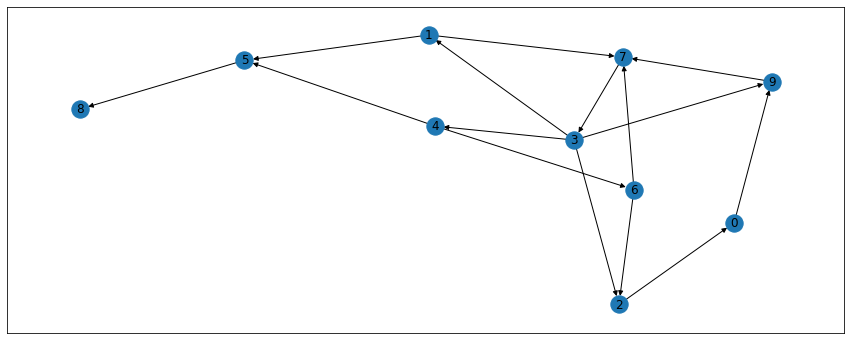

In [1405]:
fig = plt.figure(figsize=(15,6))
nx.draw_networkx(G)